In [14]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sympy as smp
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
from scipy import fftpack
from numpy import *
import numpy as np
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow
from BaselineRemoval import BaselineRemoval

import pywt

def calc_baseline(signal):
    input_array=signal
    polynomial_degree=1 #only needed for Modpoly and IModPoly algorithm
#     maxi = (diff(sign(diff(signal)))< 0).nonzero()[0] + 1
#     if signal[maxi[1]]>signal[maxi[0]]:
#         Max = signal[maxi[1]]
#     else:
#         Max = signal[maxi[0]]
    baseObj=BaselineRemoval(input_array)
    Modpoly_output=baseObj.ModPoly(polynomial_degree)
    Zhangfit_output=baseObj.ZhangFit()
    return Modpoly_output
    
def butter(order,signal,fc):
#     fc = 250
    fs = 30000
    wn = fc/15000
    b, a = scipy.signal.butter(order,wn, "low", analog=False)
    y = scipy.signal.filtfilt(b,a,signal,axis=0)
    return y

def derivate(signal):
    signal = np.array(signal)
    return np.diff(signal)

def sys_dys(signal,Plot = None):
#     signal = calc_baseline(signal)
    peaks = (diff(sign(diff(signal))) < 0).nonzero()[0] + 1
    sys = []
    sys_ind = []
    dys = []
    dys_ind = []
    for ele in peaks:
        a = min(signal[peaks])
        if signal[ele]>=(max(signal[peaks])-0.32):
            sys.append(signal[ele])
            sys_ind.append(ele)
        else:
            dys.append(signal[ele])
            dys_ind.append(ele)
            
    mini = (diff(sign(diff(signal))) > 0).nonzero()[0] + 1
    dic_not = []
    dic_ind = []
    base = []
    base_ind = []
    for ele in mini:
        if signal[ele]>=(max(signal[mini])-0.1):
            dic_not.append(signal[ele])
            dic_ind.append(ele)
        else:
            base.append(signal[ele])
            base_ind.append(ele)
    if Plot is True:
        plt.figure(figsize = (8,8))      
        plt.plot(   signal)
        plt.plot(sys_ind, signal[sys_ind], "x",label = "Systole")
        plt.plot(dys_ind, signal[dys_ind], "o",label = "Distole")
        plt.plot(dic_ind, signal[dic_ind], "^",label = "Dicrotic Notch")
        plt.plot(base_ind, signal[base_ind], "*",label = "Base")
        plt.legend()
    else:
        return sys,sys_ind,dys,dys_ind,dic_not,dic_ind,base,base_ind


def Systole_Duration(signal):
#     signal = crop(signal)
    sys,sys_ind,dys,dys_ind,dic_not,dic_ind,base,base_ind = sys_dys(signal,Plot = None)
    l = []
    l.append(dic_ind[0])
    for i in range(1,len(dic_ind)):
        l.append(dic_ind[i]-base_ind[i-1])
    return sum(l) 

def Distole_Duration(signal):
#     signal = crop(signal)
    sys,sys_ind,dys,dys_ind,dic_not,dic_ind,base,base_ind = sys_dys(signal,Plot = None)
    l = []
    l.append((len(signal) - 1)-(dic_ind[-1]))
    for i in range(0,len(base_ind)-1):
        l.append(base_ind[i]-dic_ind[i])
    return sum(l) 

def Cardiac_cycle(signal):
    sys,*_ = sys_dys(signal,Plot = None)
    return (f"{len(sys)*12}" ) #(x*60/5 = x*12)

def Heart_Rate(signal):
    sys,*_ = sys_dys(signal,Plot = None)
    return (f"{len(sys)*12} " ) #(x*60/5 = x*12)

def crop(signal):
    mini = (diff(sign(diff(signal))) > 0).nonzero()[0] + 1
#     sys,sys_ind,dys,dys_ind,dic_not,dic_ind,base,base_ind = sys_dys(signal,Plot = None)
    return signal[mini[1]:mini[-2]] if signal[mini[1]]<signal[mini[0]] else signal[mini[0]:mini[-2]]
#     return signal[base_ind[1]:base_ind[-1]]
def area_freq_resp(signal):
    f_s = 30000
    signal = np.array(signal)
    X = fftpack.fft(signal)
    return abs(X[0])

def sys_area(signal):
#     signal = crop(signal)
    *_,dic_ind,_,base_ind = sys_dys(signal,Plot = None)
    a = []
    a.append(scipy.integrate.simps(signal[0:dic_ind[0]], x=None, dx=1, axis=-1, even='avg'))
    
    for i in range(0,len(dic_ind)-1):
        a.append(scipy.integrate.simps(signal[base_ind[i]:dic_ind[i+1]], x=None, dx=1, axis=-1, even='avg'))
        
    return sum(a)/len(a)


def dia_area(signal):
#     signal = crop(signal)
    *_,dic_ind,_,base_ind = sys_dys(signal,Plot = None)
    a = []
    a.append(scipy.integrate.simps(signal[dic_ind[-1]:], x=None, dx=1, axis=-1, even='avg'))
    
    for i in range(0,len(dic_ind)-1):
        a.append(scipy.integrate.simps(signal[dic_ind[i]:base_ind[i]], x=None, dx=1, axis=-1, even='avg'))
        
    return sum(a)/len(a)


def area_diff2(signal):    
#     signal = crop(signal)
    signal = np.diff(signal)
    f_s = 30000
    X = fftpack.fft(signal)
    freqs = fftpack.fftfreq(len(signal)) * f_s
    return abs(X[0])


# using integration

def area_diff(signal):    
    signal = np.diff(signal)
    return scipy.integrate.simps(signal, x=None, dx=1, axis=-1, even='avg')

def aui(signal):
    signal = derivate(signal)
    signal = butter(2,signal,30)
    peaks = (diff(sign(diff(signal))) < 0).nonzero()[0] + 1
    plt.plot(signal)
    plt.plot(peaks, signal[peaks], "x")

    return (signal[peaks[0]]-signal[peaks[1]])/signal[peaks[0]]



def p1p2p3p4(signal):
    signal = derivate(signal)
    signal = butter(2,signal,30)
    peak = (diff(sign(diff(signal))) < 0).nonzero()[0] + 1
    d1 = signal[peak[0]]-signal[peak[1]]
    d2 =  signal[peak[2]]-signal[peak[3]]
    return [d1,d2]


def signal_rev(signal):
    
    baseline = calc_baseline(signal)
    signal = signal - baseline
    _,x,_,z,*_ = sys_dys(signal,Plot = None)

    if x[0]>z[0]:
        return signal[::-1]
    else:
        
        return signal

In [15]:
# from BaselineRemoval import BaselineRemoval
# input_array=filt0
# polynomial_degree=1 #only needed for Modpoly and IModPoly algorithm

# baseObj=BaselineRemoval(input_array)
# Modpoly_output=baseObj.ModPoly(polynomial_degree)
# Imodpoly_output=baseObj.IModPoly(polynomial_degree)
# Zhangfit_output=baseObj.ZhangFit()
# plot(Modpoly_output)

In [16]:
def trenddetector(list_of_index, array_of_data, order=1):
    result = np.polyfit(list_of_index, list(array_of_data), order)
    slope = result[-2]
    return float(slope)

In [17]:
def read_signal(path):
    signal = pd.read_csv(f"{path}",skiprows = 2)
    
    xdata = np.array(signal.iloc[:,0])
    xdatanew = (xdata+0.00025)*10000
    ydata =np.array(signal.iloc[:,1])

    signal = butter(2,ydata,250)
#     signal = crop(signal)
    p = max(signal)
    signal = calc_baseline(signal)
    q = max(signal)
    print(p/q)
    signal = crop(signal)
    _,x,_,z,*_ = sys_dys(signal,Plot = None)
    print(x)
    print(z)
    if x[0]>z[0]:
        signal =  signal[::-1]
    
#     signal = crop(signal)
    
    return sys_dys(signal,Plot  =True)

6.387050425568953
[86, 345, 605, 864, 1123, 1383]
[190, 449, 709, 968, 1229, 1488]


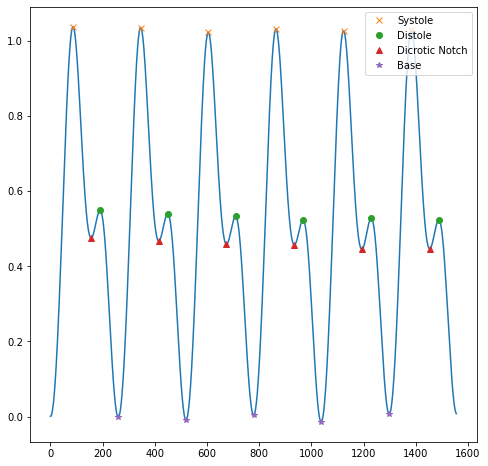

In [18]:
read_signal(r"C:\Users\Abhishek\#1 My_Thesis_Project\scopes\Good\a75.csv")

6.031768639253192
[84, 355, 627, 900, 1172, 1444]
[207, 480, 752, 1025, 1297, 1570]


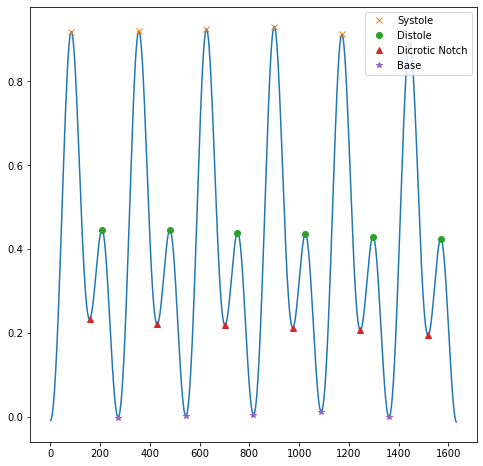

In [19]:
scope1 = pd.read_csv(r"C:\Users\Abhishek\#1 My_Thesis_Project\scopes\Good\a74.csv",skiprows =2)

xdata = np.array(scope1.iloc[:,0])
xdatanew = (xdata+0.00025)*10000
ydata =np.array(scope1.iloc[:,1])
   
filt0 = butter(2,ydata,250)



read_signal(r"C:\Users\Abhishek\#1 My_Thesis_Project\scopes\Good\a94.csv")



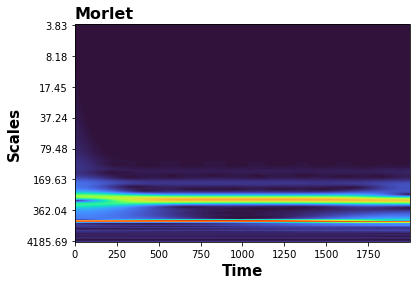

<Figure size 432x288 with 0 Axes>

In [21]:

Wx, scales =cwt(filt0, 'morlet')


imshow(abs(Wx), yticks=scales, abs=1,
       title="Morlet",
       ylabel="Scales", xlabel="Time")



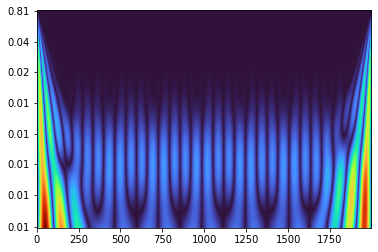

<Figure size 432x288 with 0 Axes>

In [32]:
fig = plt.figure()
scales = np.arange(1,150)
Wx, freq =pywt.cwt(filt0, scales,'morl')

imshow(abs(Wx), yticks=freq, abs=1)
plt.savefig('scalo_94.png')
fig.savefig('saved_figure.png')

In [220]:
filt0 = signal.detrend(filt0)

In [27]:
pywt.wavelist()

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',

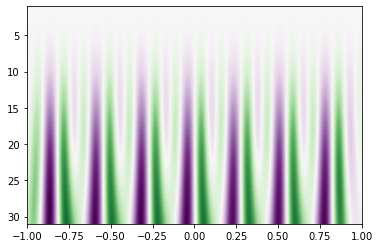

In [203]:
from scipy import signal
import matplotlib.pyplot as plt
t = xdata
# sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
widths = np.arange(1, 52)
cwtmatr = signal.cwt(filt0, signal.ricker, widths)
plt.imshow(cwtmatr, extent=[-1, 1, 31, 1], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

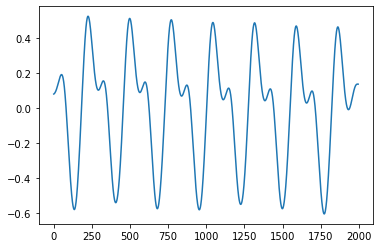

In [195]:
plt.plot(filt0)

In [596]:
trenddetector(xdata,signal)

TypeError: 'module' object is not iterable

In [437]:
trenddetector(xdata,ydata )

166.2424143954766

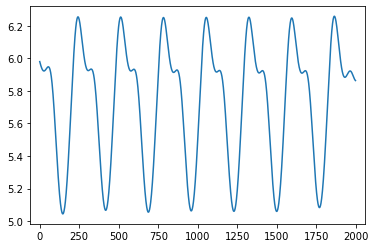

In [438]:
plot(filt0)

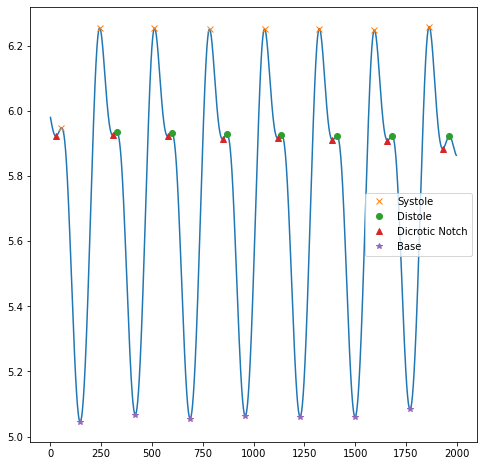

In [439]:
sys_dys(filt0,Plot =True)

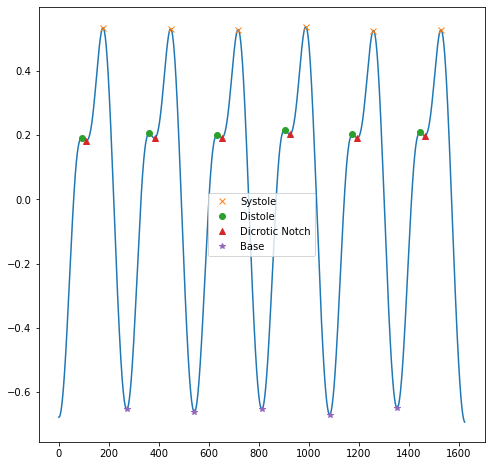

In [440]:
sys_dys(crop(signal_rev(filt0)),Plot=True)

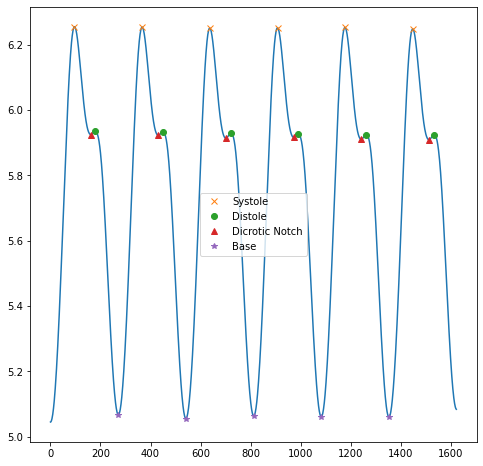

In [431]:
sys_dys(crop(filt0),Plot=True)
# plt.plot(filt0)

In [156]:
baseline = calc_baseline(filt0)

# Remove baseline from orgianl signal
ecg_out = filt0 - baseline

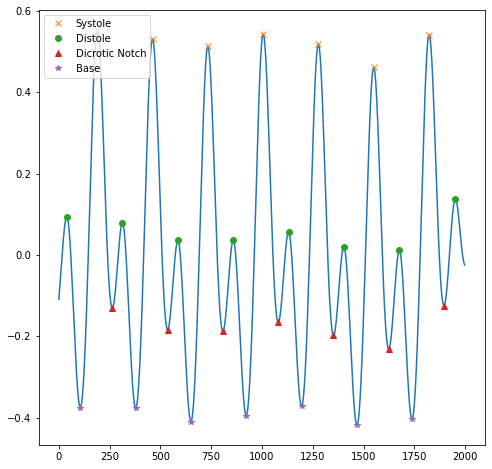

In [157]:
sys_dys(ecg_out,Plot = True)

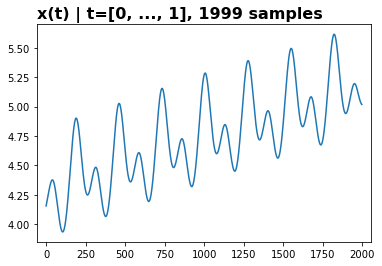

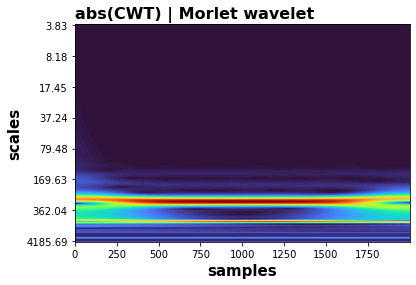

In [158]:
import numpy as np
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow



#%%# Make `x` & plot #########################################################
t = xdata
x = filt0
plot(x, title="x(t) | t=[0, ..., 1], %s samples" % len(x), show=1)

#%%# Take CWT & plot #########################################################
Wx, scales = cwt(x, 'morlet')
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet",
       ylabel="scales", xlabel="samples")

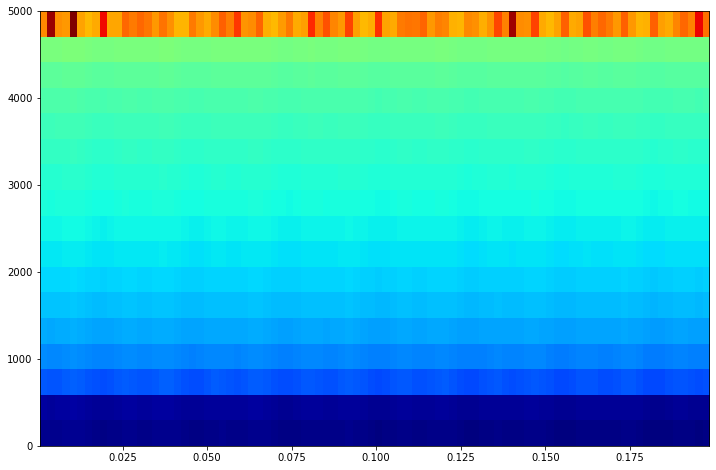

In [275]:
#  Spectrogram

plt.figure(figsize=(12,8))

plt.specgram(filt0,NFFT = 32,noverlap=10,Fs = 10000,cmap="jet_r")
plt.show()

In [96]:
X = np.array(filt0.index.tolist())
y = np.array(filt0.Value)
model = np.poly1d(np.polyfit(X, y, 4))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

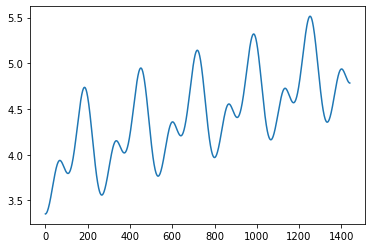

In [31]:
plt.plot(filt0)

# Signals to be reversed:
    
a7
a13


# Signals useless
a14
a15-a27


# Signals Usefull

a52 ,a53,a54

In [13]:
np.zeros((3))

array([0., 0., 0.])

In [14]:
x =[1,2,3,4,5]

x[:-1]

[1, 2, 3, 4]

In [636]:
s = "10218312"

In [633]:
i = next(i for i,a in enumerate(s) if a > '0')

In [640]:
[i for i,a in enumerate(s) if a >'0']

[0, 2, 3, 4, 5, 6, 7]

In [122]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [130]:
filt0

array([3.22959229, 3.23653145, 3.24347062, ..., 4.78004447, 4.78585247,
       4.79166112])

In [128]:
filt0 = baseline_als(filt0, lam=100,p=1e-6, niter=10)

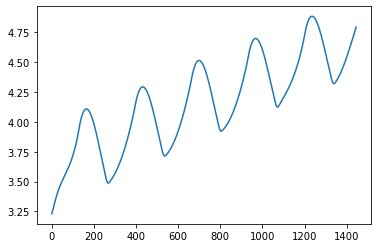

In [129]:
plt.plot(filt0)

In [ ]:
# def calc_baseline(signal):
#     """
#     Calculate the baseline of signal.
#     Args:
#         signal (numpy 1d array): signal whose baseline should be calculated
#     Returns:
#         baseline (numpy 1d array with same size as signal): baseline of the signal
#     """
#     ssds = np.zeros((3))

#     cur_lp = np.copy(signal)
#     iterations = 0
#     while True:
#         # Decompose 1 level
#         lp, hp = pywt.dwt(cur_lp, "db4")

#         # Shift and calculate the energy of detail/high pass coefficient
#         ssds = np.concatenate(([np.sum(hp ** 2)], ssds[:-1]))

#         # Check if we are in the local minimum of energy function of high-pass signal
#         if ssds[2] > ssds[1] and ssds[1] < ssds[0]:
#             break

#         cur_lp = lp[:]
#         iterations += 1

#     # Reconstruct the baseline from this level low pass signal up to the original length
#     baseline = cur_lp[:]
#     for _ in range(iterations):
#         baseline = pywt.idwt(baseline, np.zeros((len(baseline))), "db4")

#     return baseline[: len(signal)]